In [2]:
import re
import string
import fasttext
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import nltk
nltk.download('stopwords')
class LanguageIdentification:
    """
    Class object for Language Identification
    """

    def __init__(self):
        """
        Initializing class objects
        """
        pretrained_lang_model = "lid.176.ftz"
        self.model = fasttext.load_model(pretrained_lang_model)

    def predict_lang(self, text):
        """
        Attributes
        text: type str, the sentence for which language is to be identified
        """
        predictions = self.model.predict(text, k=1) # top 1 matching languages
        return predictions

def normalize(tweet):
    try:
        tweet = tweet.encode('unicode-escape').replace(b'\\\\u', b'\\u').decode('unicode-escape').tweet.encode('utf-8', 'ignore').decode('utf-8')
    except:
        pass
    tweet = tweet.replace("\n", " ")
    return tweet

def tokenize(tweet):
    stop_words = set(stopwords.words('english') + ['rt', '…'])
    tokens = TweetTokenizer().tokenize(tweet)
    tokens = list(filter(lambda token: not re.match('^n?https?.+$', token), tokens))
    tokens = list(filter(lambda token: not re.match('^(u.+|n)$', token), tokens))
    tokens = list(filter(lambda token: token not in string.punctuation, tokens))
    tokens = list(filter(lambda token: not re.match('^[.]+$', token), tokens))
    tokens = list(filter(lambda token: not re.match('^[0-9]+$', token), tokens))
    tokens = [token.lower() for token in tokens]
    tokens = list(filter(lambda token: token not in stop_words, tokens))
    return tokens


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/benjamin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
dataset = 'Tweets.csv'
dataframe = pd.read_csv(dataset, sep='\t', encoding='utf8')
tweets = dataframe['Tweet'].tolist()
tweets = [normalize(tweet) for tweet in tweets]
languages = LanguageIdentification().predict_lang(tweets)[0]
languages = [language[0].replace('__label__', '') for language in languages]
dataframe['language'] = languages
dataframe['Tweet'] = tweets
dataframe.to_csv('normalized_dataset.csv', sep='\t', index=False)
#tokenized_tweets = [tokenize(tweet) for tweet in tweets]
#print(tokenized_tweets)

<AxesSubplot:>

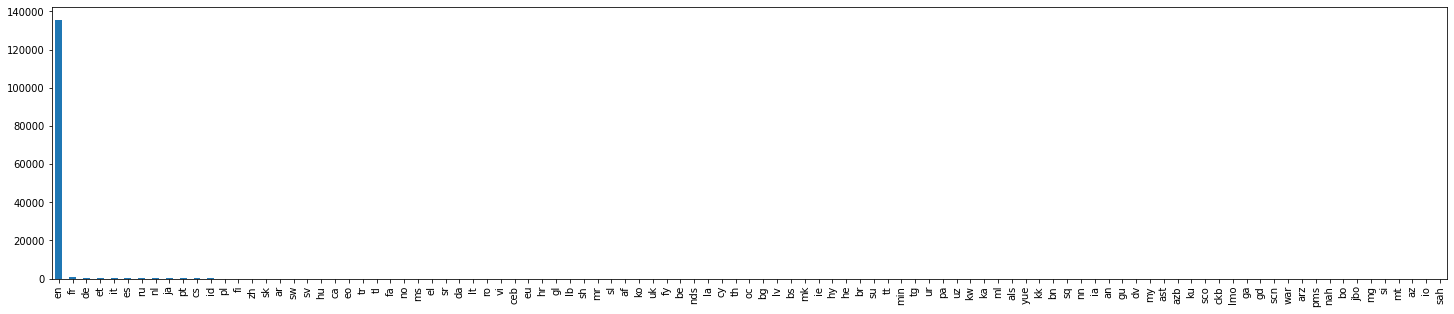

In [6]:
pd.value_counts(dataframe['language']).plot.bar(figsize=(25,5))

In [7]:
non_english_df = dataframe[dataframe['language']!='en']

<AxesSubplot:>

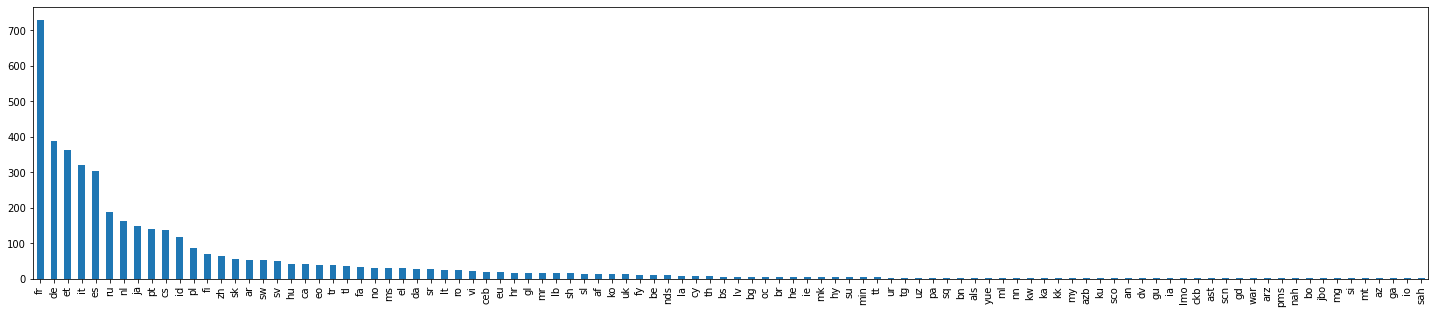

In [8]:
pd.value_counts(non_english_df['language']).plot.bar(figsize=(25,5))

<AxesSubplot:>

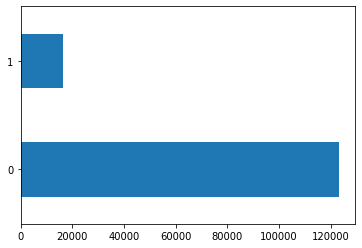

In [9]:
pd.value_counts(dataframe['ISIS Flag']).plot.barh()

<AxesSubplot:>

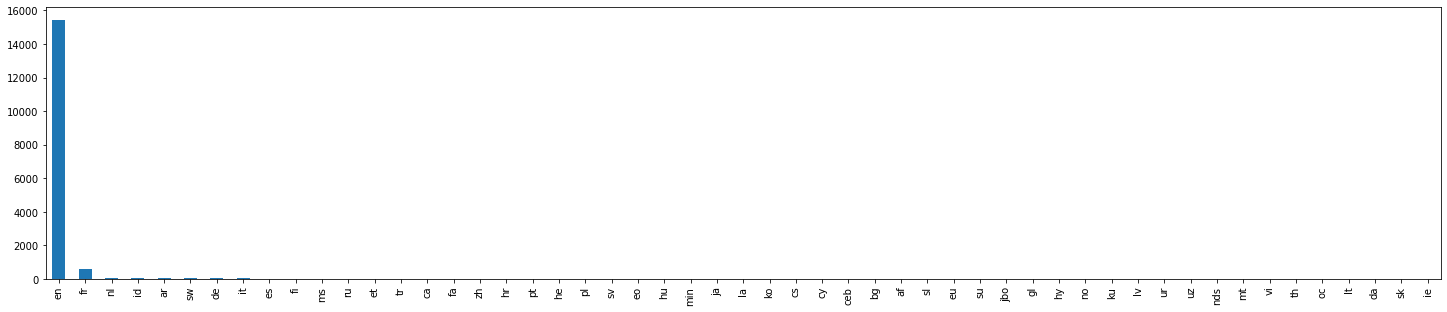

In [12]:
positive_dataframe = dataframe[dataframe['ISIS Flag']==1]
pd.value_counts(positive_dataframe['language']).plot.bar(figsize=(25,5))

<AxesSubplot:>

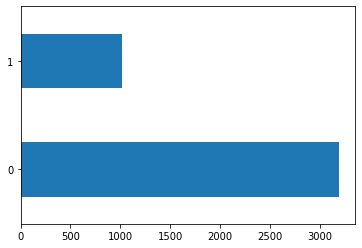

In [14]:
non_english_dataframe = dataframe[dataframe['language']!='en']
pd.value_counts(non_english_dataframe['ISIS Flag']).plot.barh()

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

def get_common_phrases(tweets):
    tokenized_positive_tweets = [tokenize(tweet) for tweet in tweets]
    phrase_model = Phrases(tokenized_positive_tweets, min_count=1, threshold=1, connector_words=ENGLISH_CONNECTOR_WORDS)
    corpus = [phrase for phrase in phrase_model[tokenized_positive_tweets]]
    dictionary = Dictionary(corpus)
    return dictionary.most_common(n=1000)

def create_wordcloud(frequencies):
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(frequencies)
    plt.figure(figsize=(15, 15))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

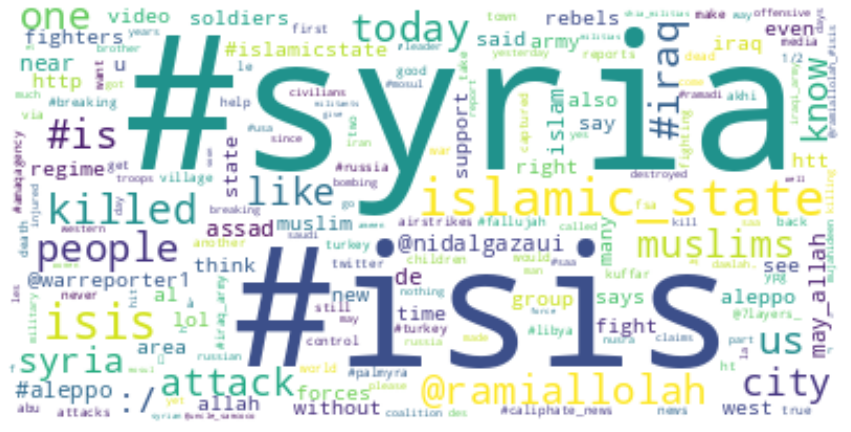

In [5]:

positive_dataframe = dataframe[dataframe['ISIS Flag']==1]
positive_tweets = positive_dataframe['Tweet'].to_list()
common_phrases = get_common_phrases(positive_tweets)
frequencies = {word[0]: word[1] for word in common_phrases}
create_wordcloud(frequencies)

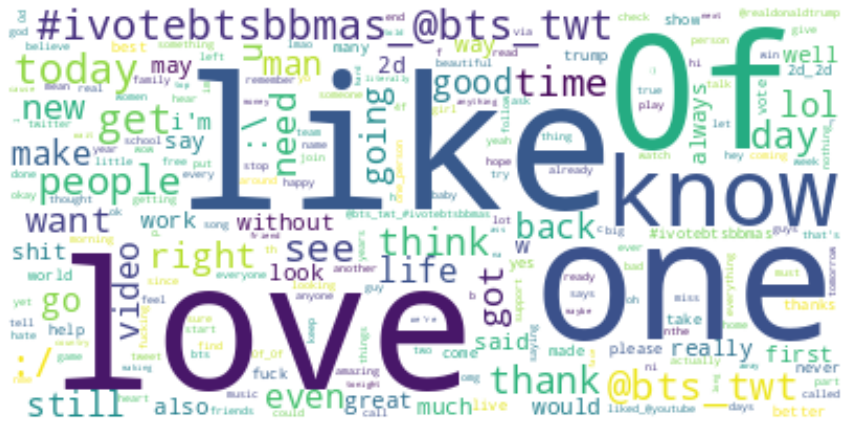

In [6]:
negative_dataframe = dataframe[dataframe['ISIS Flag']==0]
negative_tweets = negative_dataframe['Tweet'].to_list()
common_phrases = get_common_phrases(negative_tweets)
frequencies = {word[0]: word[1] for word in common_phrases}
create_wordcloud(frequencies)

In [7]:
import random
random.shuffle(negative_tweets)
negative_tweets_undersampled = negative_tweets[:len(positive_tweets)]

positive_tweets = [[tweet, 1] for tweet in positive_tweets]
negative_tweets_undersampled = [[tweet, 0] for tweet in negative_tweets_undersampled]

all_tweets = positive_tweets + negative_tweets_undersampled 
random.shuffle(all_tweets)
dataset_dataframe = pd.DataFrame(all_tweets, columns=['text', 'label'])
texts = dataset_dataframe['text'].to_list()
texts = [normalize(text) for text in texts]
tokenized_texts = [tokenize(text) for text in texts]
labels = dataset_dataframe['label'].to_list()

In [14]:
from tensorflow.keras.preprocessing import text
import numpy as np
tokenizer = text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tokenized_texts)
X = tokenizer.texts_to_matrix(tokenized_texts, mode="tfidf")
y = np.array(labels)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, Activation, Dropout

model = Sequential()
model.add(Dense(50, input_shape=(10000,)))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", Precision(), Recall()])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 50)                500050    
                                                                 
 activation_10 (Activation)  (None, 50)                0         
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
 activation_11 (Activation)  (None, 1)                 0         
                                                                 
Total params: 500,101
Trainable params: 500,101
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X, y, batch_size=16, epochs=3, validation_split=0.25, verbose=2)

2021-11-23 23:51:55.429956: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 986760000 exceeds 10% of free system memory.


Epoch 1/3
1542/1542 - 5s - loss: 0.2502 - accuracy: 0.8987 - precision_1: 0.9169 - recall_1: 0.8766 - val_loss: 0.1689 - val_accuracy: 0.9400 - val_precision_1: 0.9559 - val_recall_1: 0.9233 - 5s/epoch - 4ms/step
Epoch 2/3
1542/1542 - 5s - loss: 0.1126 - accuracy: 0.9568 - precision_1: 0.9702 - recall_1: 0.9424 - val_loss: 0.1768 - val_accuracy: 0.9409 - val_precision_1: 0.9548 - val_recall_1: 0.9262 - 5s/epoch - 3ms/step
Epoch 3/3
1542/1542 - 4s - loss: 0.0728 - accuracy: 0.9722 - precision_1: 0.9831 - recall_1: 0.9609 - val_loss: 0.1964 - val_accuracy: 0.9396 - val_precision_1: 0.9462 - val_recall_1: 0.9327 - 4s/epoch - 3ms/step
